In [237]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn import linear_model

import math

sns.set()

random_state = 123_456
np.random.seed(random_state)

In [238]:
# import sys
# !{sys.executable} -m pip install --force-reinstall fbprophet
# !{sys.executable} -m pip install --upgrade pandas
# !{sys.executable} -m pip install sklearn

In [239]:
df = pd.read_csv('fuel-prices/all_features_combined.csv', index_col='date', dtype={'price': np.int32, 
                 'tapis_oil_price': np.int32, 'national_avg_price': np.int32}, parse_dates=True)
df.set_index(pd.date_range(min(df.index), periods=df.shape[0], freq='D'), inplace=True, verify_integrity=True)

In [240]:
# df.info()

In [241]:
features = ['price','price_t_plus_1']

In [242]:
df = df[df.index >= '2019-12-24'][features]
# df.drop(df[df.index > '2019-12-30'].index, inplace=True)
df['price_t_minus_1'] = df.price.shift(1)
df['price_t_minus_2'] = df.price.shift(2)
df.dropna(inplace=True)
df.price_t_minus_1 = df.price_t_minus_1.astype('int')
df.price_t_minus_2 = df.price_t_minus_2.astype('int')
df

price  price_t_plus_1  price_t_minus_1  price_t_minus_2
2019-12-26   1605            1608             1626             1657
2019-12-27   1608            1589             1605             1626
2019-12-28   1589            1579             1608             1605
2019-12-29   1579            1602             1589             1608
2019-12-30   1602            1609             1579             1589
2019-12-31   1609            1609             1602             1579

In [243]:
df['price_diff_1'] = df.apply(lambda se: se.price - se.price_t_minus_1, axis=1)
df['price_diff_2'] = df.apply(lambda se: se.price - 2 * se.price_t_minus_1 + se.price_t_minus_2, axis=1)

In [244]:
df

price  price_t_plus_1  price_t_minus_1  price_t_minus_2  \
2019-12-26   1605            1608             1626             1657   
2019-12-27   1608            1589             1605             1626   
2019-12-28   1589            1579             1608             1605   
2019-12-29   1579            1602             1589             1608   
2019-12-30   1602            1609             1579             1589   
2019-12-31   1609            1609             1602             1579   

            price_diff_1  price_diff_2  
2019-12-26           -21            10  
2019-12-27             3            24  
2019-12-28           -19           -22  
2019-12-29           -10             9  
2019-12-30            23            33  
2019-12-31             7           -16

In [245]:
X = df.price.values.reshape(-1,1)
y = df.price_t_plus_1.values.reshape(-1,1)
# y

In [246]:
reg = linear_model.LinearRegression()
# reg.fit(df.price_diff_2.values.reshape(-1,1), df.price_t_plus_1.values.reshape(-1,1))
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [247]:
r_2 = reg.score(X, y)
r_2

0.09618441971382707

In [248]:
r_2_adjusted = 1 - (1 - r_2) * ((X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1))
r_2_adjusted

-0.1297694753577161

In [249]:
y_hat = np.rint(reg.predict(X)).reshape(1,-1)[0]
# y_hat
y_true = df.price_t_plus_1.values
# y_true
# y_hat.reshape(1,-1)[0]
# df.price_t_plus_1.values.reshape(1,-1)[0]
# mean_absolute_error(df.price_t_plus_1.values.reshape(-1,1), y_hat) # 9.5

In [250]:
# y = np.array([1608, 1589, 1579, 1602, 1609, 1609])
# y_hat = np.array([1600., 1603., 1594., 1600., 1605., 1595])
aa = y_true - y_hat
# print(aa)
aa = aa / y_true
# print(aa)
aa = np.abs(aa)
# print(aa)
# print(aa.sum())
aa.sum() / aa.size * 100

0.637355430200475

In [251]:
# from sklearn.utils import check_arrays
from sklearn.utils.validation import check_array as check_arrays

# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [253]:
# df.price_t_plus_1.values
# y_hat.reshape(1,-1)[0]
mean_absolute_percentage_error(df.price_t_plus_1.values, y_hat.reshape(1,-1)[0])

0.637355430200475

In [218]:
def get_relative_accuracy(y_test, y_hat, tolerance_percentage):
    it = np.nditer(y_test, flags=['f_index'])
    non_error_count = 0
    
    while not it.finished:
        upper_limit = it[0] * (1 + tolerance_percentage / 100)
        lower_limit = it[0] - (upper_limit - it[0])
#         print(round(lower_limit), round(upper_limit), y_hat[it.index], round(upper_limit - lower_limit))
        non_error_count += 1 if y_hat[it.index] < upper_limit and y_hat[it.index] > lower_limit else 0
        it.iternext()
        
    return non_error_count / y_test.size

In [219]:
error_tolerance_percentage = 2.5
get_relative_accuracy(df.price_t_plus_1.values, y_hat.reshape(1,-1)[0], error_tolerance_percentage)

1.0

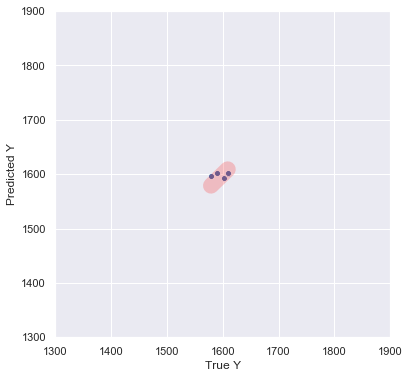

In [220]:
line_x_y = [math.floor(min(y_true.min(),y_hat.min())), math.ceil(max(y_true.max(),y_hat.max()))]
_ = plt.figure(figsize = (6, 6))
_ = plt.ylim(1300, 1900)
_ = plt.xlim(1300, 1900)
_ = plt.plot(line_x_y, line_x_y, linewidth=16, alpha=0.2, color='red')
_ = sns.scatterplot(y_true, y_hat)
_ = plt.ylabel('Predicted Y')
_ = plt.xlabel('True Y')
plt.show()

In [186]:
# import pandas_profiling
# df.profile_report(style={'full_width':True})

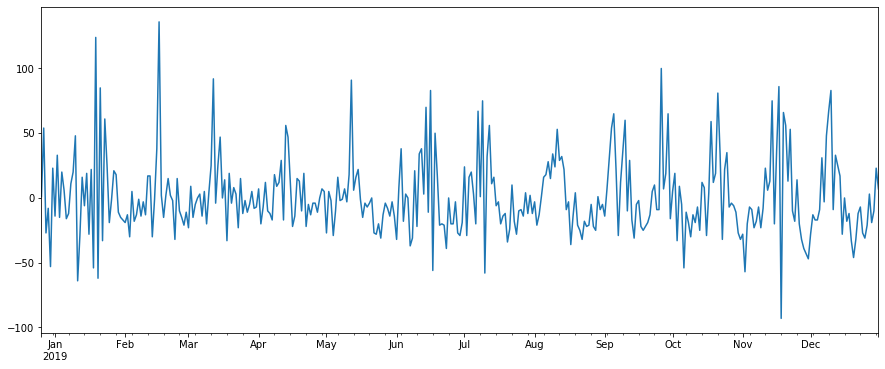

In [183]:
plt.figure(figsize = (15, 6))
df.price_diff_1.plot()

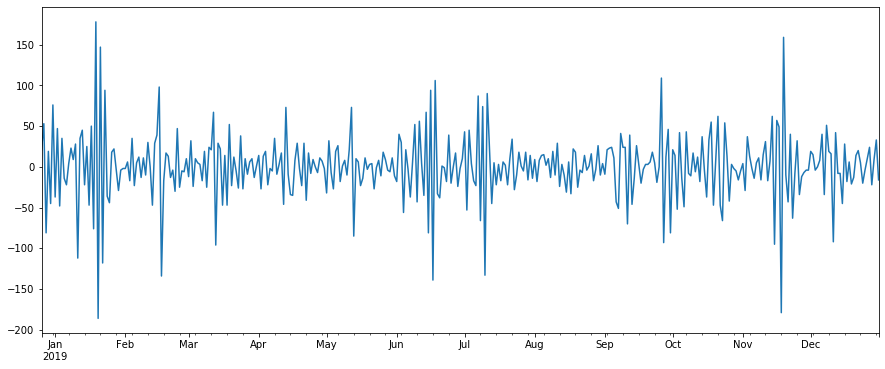

In [184]:
plt.figure(figsize = (15, 6))
df.price_diff_2.plot()

In [ ]:
df.price.mean()

In [ ]:
df.price.std()

In [ ]:
df.price_diff.mean()

In [ ]:
df.price_diff.std()

In [ ]:
1609-1845

In [ ]:
df.price.plot()

In [ ]:
df.price_diff.plot()